<a href="https://colab.research.google.com/github/inf14/Anant-Jain---23FE10CSE00483---ML-LAB/blob/main/ML_LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


#required packages
!pip install plotly pandas numpy scikit-learn missingno ipywidgets --quiet

#Imports
import os, zipfile
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from IPython.display import display, Markdown

# Config
SHOW_EDA = True
RANDOM_STATE = 42


# 1) Upload & extract dataset
print("Upload the ZIP file containing the Student performance dataset (the same zip you used before).")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
print(f"Uploaded file: {zip_path}")

extract_dir = '/content/superstore_dataset'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extracted to: {extract_dir}")

# find the first plausible data file (.csv, .xls, .xlsx)
possible_files = []
for root, _, files_list in os.walk(extract_dir):
    for fname in files_list:
        if fname.lower().endswith(('.xls', '.xlsx', '.csv')):
            possible_files.append(os.path.join(root, fname))

if not possible_files:
    raise FileNotFoundError("No .xls/.xlsx/.csv file found in the uploaded zip. Please upload the Student performnace zip that contains the dataset.")

print("Possible data files found:")
for i, p in enumerate(possible_files):
    print(i, p)

# choose first file by default (change index if you want another)
data_path = possible_files[0]
print(f"\nLoading data from: {data_path}")

# load the dataset
if data_path.lower().endswith('.csv'):
    df = pd.read_csv(data_path, low_memory=False)
else:
    df = pd.read_excel(data_path)

print("\nInitial dataset shape:", df.shape)
display(df.head())



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00
Upload the ZIP file containing the Student performance dataset (the same zip you used before).


Saving archive (2).zip to archive (2).zip
Uploaded file: archive (2).zip
Extracted to: /content/superstore_dataset
Possible data files found:
0 /content/superstore_dataset/German Credit Data.xlsx

Loading data from: /content/superstore_dataset/German Credit Data.xlsx

Initial dataset shape: (1000, 21)


,checking account status,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,employment,Installment,status n sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,existing credits no.,Job,liability responsibles,Telephone,foreign worker,Category
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [2]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   checking account status      1000 non-null   object
 1   Duration in month            1000 non-null   int64 
 2   Credit history               1000 non-null   object
 3   Purpose                      1000 non-null   object
 4   Credit amount                1000 non-null   int64 
 5   Savings account/bonds        1000 non-null   object
 6   employment                   1000 non-null   object
 7    Installment                 1000 non-null   int64 
 8   status n sex                 1000 non-null   object
 9    Other debtors / guarantors  1000 non-null   object
 10  residence                    1000 non-null   int64 
 11  Property                     1000 non-null   object
 12  Age in years                 1000 non-null   int64 
 13  Other installment plans      1000 

In [3]:
df.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

,Duration in month,Credit amount,Installment,residence,Age in years,existing credits no.,liability responsibles,Category
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
10%,9.000000,932.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
90%,36.000000,7179.400000,4.000000,4.000000,52.000000,2.000000,2.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [4]:
df.columns

Index(['checking account status', 'Duration in month', 'Credit history',
       'Purpose', 'Credit amount', 'Savings account/bonds', 'employment',
       ' Installment', 'status n sex', ' Other debtors / guarantors',
       'residence', 'Property', 'Age in years', 'Other installment plans',
       'Housing', 'existing credits no.', 'Job', 'liability responsibles',
       'Telephone', 'foreign worker', 'Category'],
      dtype='object')

In [5]:
l_column = list(df.columns) # Making a list out of column names
len_feature = len(l_column) # Length of column vector list
l_column

['checking account status',
 'Duration in month',
 'Credit history',
 'Purpose',
 'Credit amount',
 'Savings account/bonds',
 'employment',
 ' Installment',
 'status n sex',
 ' Other debtors / guarantors',
 'residence',
 'Property',
 'Age in years',
 'Other installment plans',
 'Housing',
 'existing credits no.',
 'Job',
 'liability responsibles',
 'Telephone',
 'foreign worker',
 'Category']

In [6]:
import numpy as np

# Select only int and float columns
numeric_df = df.select_dtypes(include=[np.number])

numeric_df.columns


Index(['Duration in month', 'Credit amount', ' Installment', 'residence',
       'Age in years', 'existing credits no.', 'liability responsibles',
       'Category'],
      dtype='object')

In [7]:
X = numeric_df.drop(columns=['Category'])
y = numeric_df['Category']


In [8]:
l_column = list(numeric_df.columns)
len_feature = len(l_column)

X = numeric_df[l_column[0:len_feature-1]]
y = numeric_df[l_column[len_feature-1]]


In [9]:
print("Feature set size:",X.shape)
print("Variable set size:",y.shape)

Feature set size: (1000, 7)
Variable set size: (1000,)


In [10]:
X.head()

,Duration in month,Credit amount,Installment,residence,Age in years,existing credits no.,liability responsibles
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


In [11]:
y.head()

,Category
0,1
1,2
2,1
3,1
4,2


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Define features and target
X = numeric_df.drop(columns=['Category'])
y = numeric_df['Category']

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=123
)


In [14]:
print("Training feature set size:",X_train.shape)
print("Test feature set size:",X_test.shape)
print("Training variable set size:",y_train.shape)
print("Test variable set size:",y_test.shape)

Training feature set size: (700, 7)
Test feature set size: (300, 7)
Training variable set size: (700,)
Test variable set size: (300,)


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [16]:
lm = LinearRegression() # Creating a Linear Regression object 'lm'

In [17]:
lm.fit(X_train,y_train) # Fit the linear model on to the 'lm' object itself i.e. no need to set this to another variable

LinearRegression()

In [18]:
print("The intercept term of the linear model:", lm.intercept_)

The intercept term of the linear model: 1.1383421205974984


In [19]:
print("The coefficients of the linear model:", lm.coef_)

The coefficients of the linear model: [ 7.62449615e-03  6.51023508e-06  2.56555695e-02  6.58647908e-03
 -3.08383387e-03 -3.31853035e-02  2.96807545e-02]


In [20]:
#idict = {'Coefficients':lm.intercept_}
#idf = pd.DataFrame(data=idict,index=['Intercept'])
cdf = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=["Coefficients"])
#cdf=pd.concat([idf,cdf], axis=0)
cdf

,Coefficients
Duration in month,0.007624
Credit amount,0.000007
Installment,0.025656
residence,0.006586
Age in years,-0.003084
existing credits no.,-0.033185
liability responsibles,0.029681


In [21]:
import numpy as np

# Number of samples and features
n = X_train.shape[0]
k = X_train.shape[1]

# Degrees of freedom
dfN = n - k

# Predictions on training data
train_pred = lm.predict(X_train)

# Squared errors
train_error = np.square(train_pred - y_train)
sum_error = np.sum(train_error)

# Initialize standard error list dynamically
se = np.zeros(k)

# Compute standard error for each coefficient
for i in range(k):
    r = sum_error / dfN
    denom = np.sum(
        np.square(
            X_train.iloc[:, i] - X_train.iloc[:, i].mean()
        )
    )
    r = r / denom
    se[i] = np.sqrt(r)

# Add results to coefficient dataframe
cdf['Standard Error'] = se
cdf['t-statistic'] = cdf['Coefficients'] / cdf['Standard Error']

cdf


,Coefficients,Standard Error,t-statistic
Duration in month,0.007624,0.001455,5.241868
Credit amount,0.000007,0.000006,1.007367
Installment,0.025656,0.014872,1.725095
residence,0.006586,0.014902,0.441999
Age in years,-0.003084,0.001437,-2.146477
existing credits no.,-0.033185,0.028821,-1.151412
liability responsibles,0.029681,0.047300,0.627502


In [22]:
print(
    "Therefore, features arranged in the order of importance for predicting credit risk\n",
    '-' * 90,
    sep=''
)

# Sort features by absolute t-statistic (more correct statistically)
l = list(
    cdf.reindex(
        cdf['t-statistic'].abs().sort_values(ascending=False).index
    ).index
)

print(' > \n'.join(l))


Therefore, features arranged in the order of importance for predicting credit risk
------------------------------------------------------------------------------------------
Duration in month > 
Age in years > 
 Installment > 
existing credits no. > 
Credit amount > 
liability responsibles > 
residence


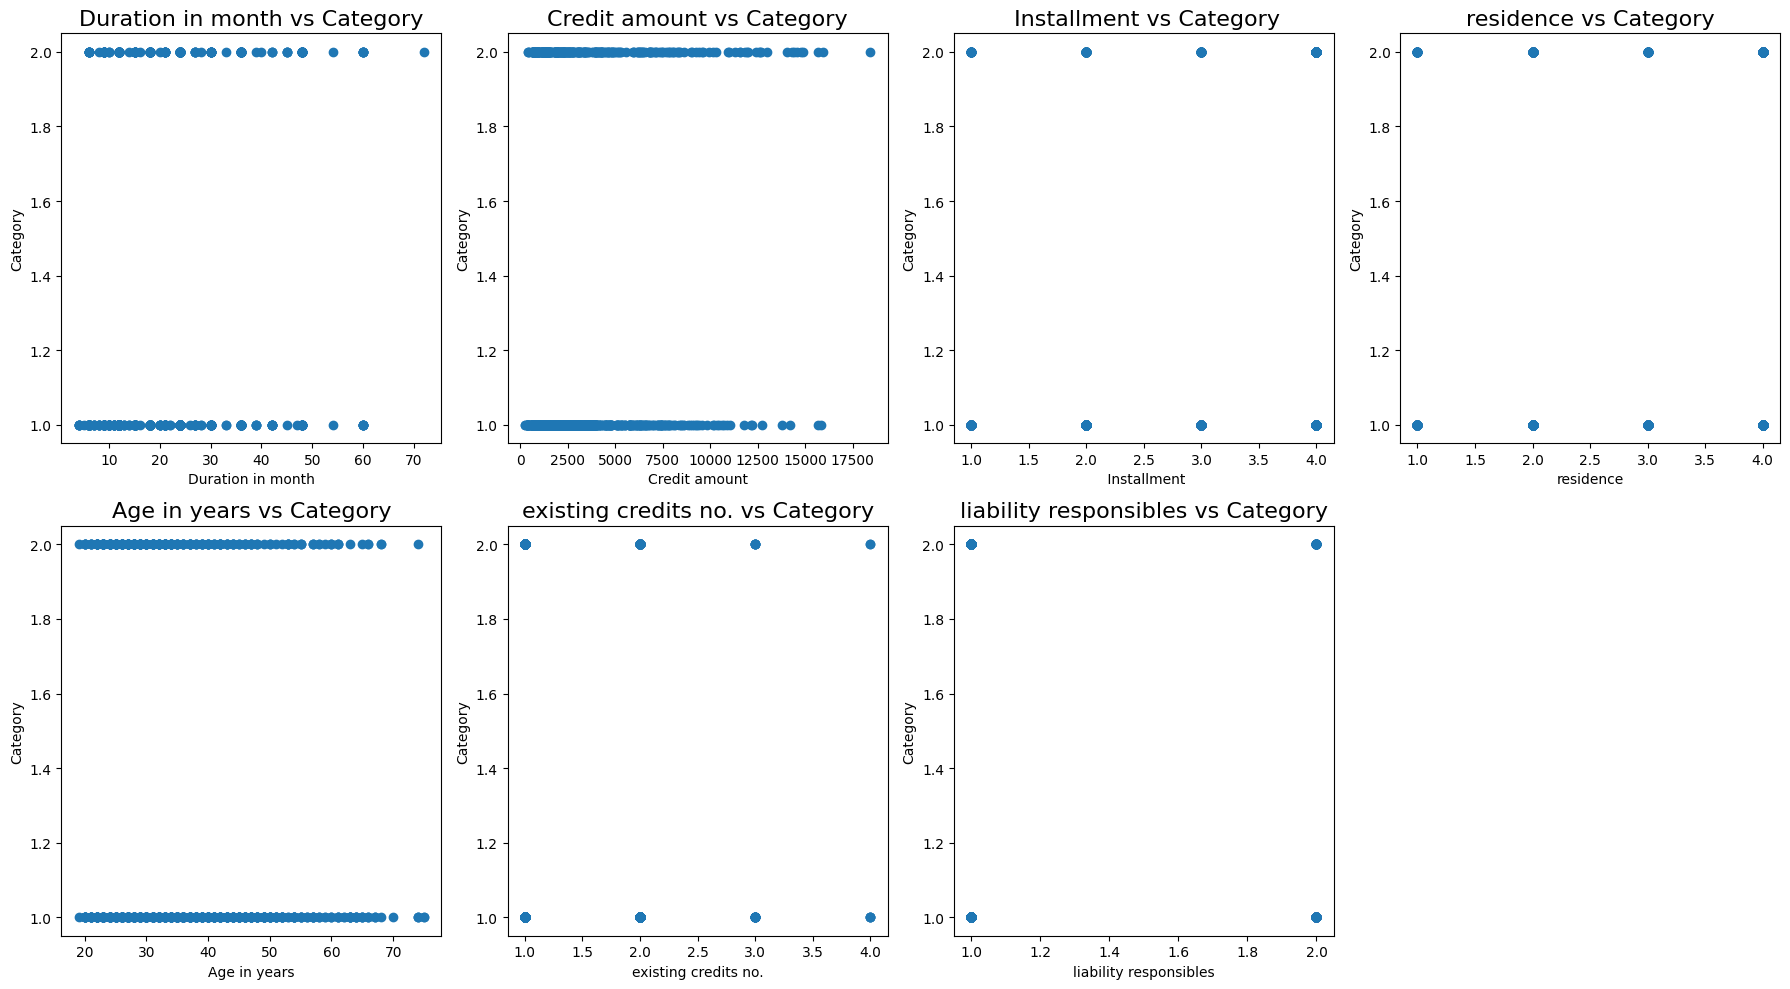

In [23]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Feature list (from coefficient dataframe)
l = list(cdf.index)

# Create figure
fig = plt.figure(figsize=(18, 10))

# Grid: 2 rows × 4 columns (enough for 7 features)
gs = gridspec.GridSpec(2, 4)

for i, feature in enumerate(l):
    ax = plt.subplot(gs[i])
    ax.scatter(df[feature], df['Category'])
    ax.set_title(f"{feature} vs Category", fontdict={'fontsize': 16})
    ax.set_xlabel(feature)
    ax.set_ylabel("Category")

plt.tight_layout()
plt.show()


In [24]:
print("R-squared value of this fit:",round(metrics.r2_score(y_train,train_pred),3))

R-squared value of this fit: 0.062


In [25]:
predictions = lm.predict(X_test)
print ("Type of the predicted object:", type(predictions))
print ("Size of the predicted object:", predictions.shape)

Type of the predicted object: <class 'numpy.ndarray'>
Size of the predicted object: (300,)


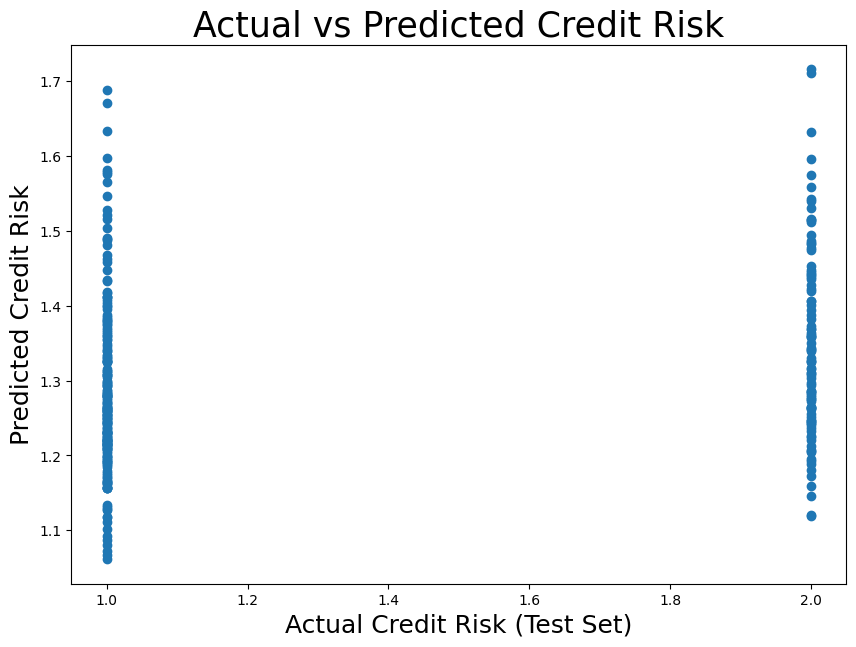

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Actual vs Predicted Credit Risk", fontsize=25)
plt.xlabel("Actual Credit Risk (Test Set)", fontsize=18)
plt.ylabel("Predicted Credit Risk", fontsize=18)

plt.scatter(x=y_test, y=predictions)
plt.show()


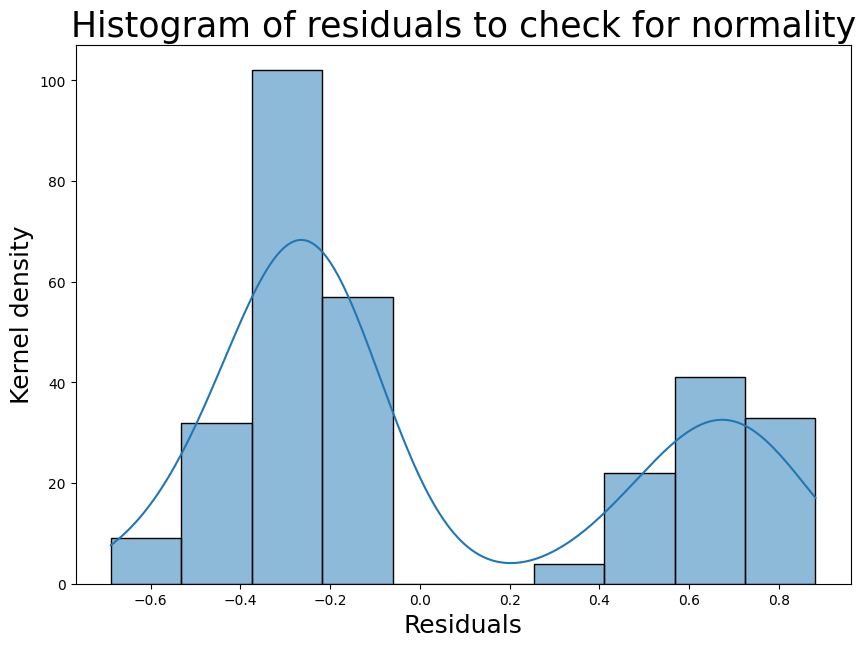

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals
residuals = y_test - predictions

plt.figure(figsize=(10, 7))
plt.title("Histogram of residuals to check for normality", fontsize=25)
plt.xlabel("Residuals", fontsize=18)
plt.ylabel("Kernel density", fontsize=18)

sns.histplot(residuals, kde=True)
plt.show()


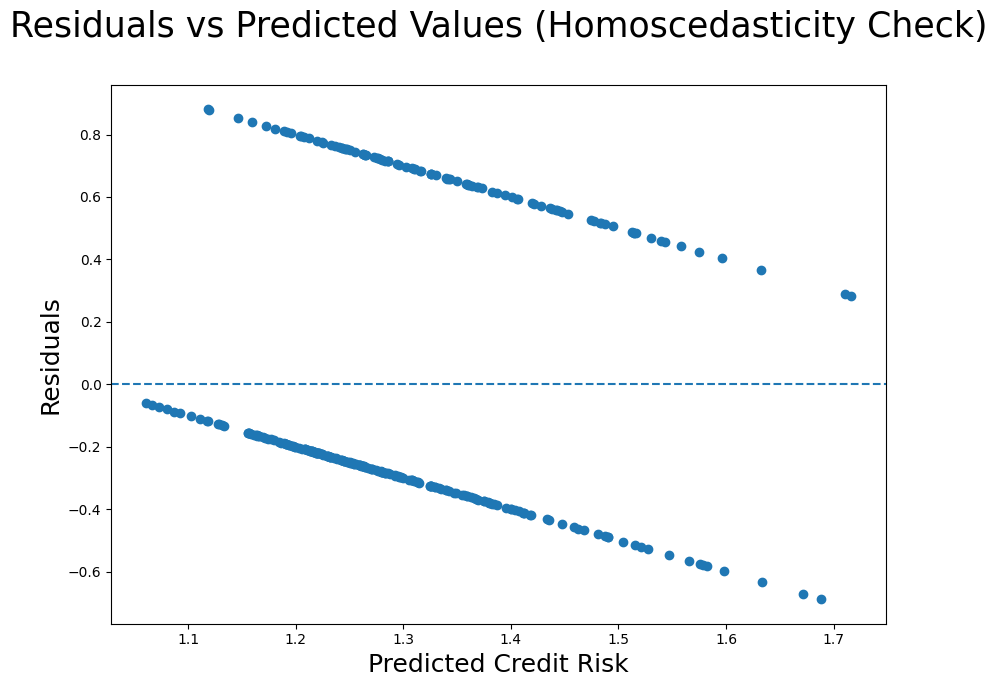

In [28]:
import matplotlib.pyplot as plt

# Compute residuals
residuals = y_test - predictions

plt.figure(figsize=(10, 7))
plt.title(
    "Residuals vs Predicted Values (Homoscedasticity Check)\n",
    fontsize=25
)
plt.xlabel("Predicted Credit Risk", fontsize=18)
plt.ylabel("Residuals", fontsize=18)

plt.scatter(x=predictions, y=residuals)
plt.axhline(y=0, linestyle='--')  # reference line
plt.show()


In [29]:
from sklearn import metrics
import numpy as np

print("Mean Absolute Error (MAE):",
      metrics.mean_absolute_error(y_test, predictions))

print("Mean Squared Error (MSE):",
      metrics.mean_squared_error(y_test, predictions))

print("Root Mean Squared Error (RMSE):",
      np.sqrt(metrics.mean_squared_error(y_test, predictions)))


Mean Absolute Error (MAE): 0.40822596754190554
Mean Squared Error (MSE): 0.2109897945583658
Root Mean Squared Error (RMSE): 0.45933625434790776


In [30]:
print("R-squared value of predictions:",round(metrics.r2_score(y_test,predictions),3))

R-squared value of predictions: 0.051


In [31]:
import numpy as np

min_val = np.min(predictions)
max_val = np.max(predictions)

print(min_val, max_val)


1.0613491260635066 1.7161581295301118


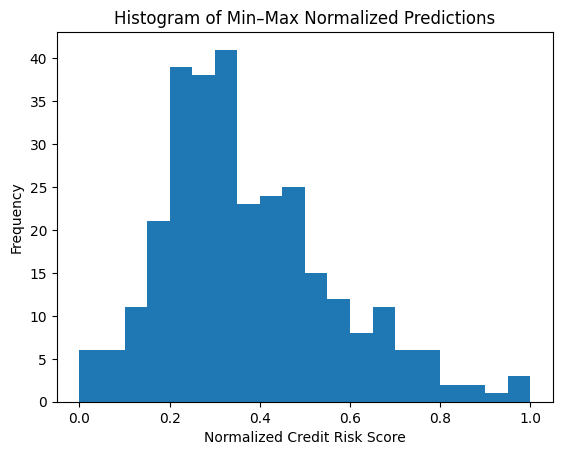

In [32]:
normalized_predictions = (predictions - min_val) / (max_val - min_val)

plt.hist(normalized_predictions, bins=20)
plt.title("Histogram of Min–Max Normalized Predictions")
plt.xlabel("Normalized Credit Risk Score")
plt.ylabel("Frequency")
plt.show()
